In [1]:
import math
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandas import json_normalize
import yaml
from yaml import CSafeLoader as Loader

sns.set_context("paper", font_scale=3)

LOG_DIR = os.path.expanduser("~/jean-zay/emergent_communication/lightning_logs/")

REFERENCE_METRIC = "val_acc"

In [2]:
results_df = []
for run_dir in tqdm(os.listdir(LOG_DIR)):
    run_path = os.path.join(LOG_DIR, run_dir, "checkpoints/")

    results = glob.glob(run_path+f"*{REFERENCE_METRIC}=*.pickle")
    for result in results:
        df = pd.read_pickle(result)
        df = pd.DataFrame.from_records(df)
        df["dir_name"] = run_dir
        df["epoch"] = int(result.split("epoch=")[1].split("-")[0])
        results_df.append(df)


results_df = pd.concat(results_df, ignore_index=True)

# Remove superfluous NaN cells
def compress(values):
    for val in values:
        if val is not None and not np.isnan(val):
            return val

results_df = results_df.groupby(["dir_name", "epoch"]).aggregate(compress)
results_df.reset_index(inplace=True)
results_df

100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


,dir_name,epoch,receiver_loss/dataloader_idx_0,entropy_loss/dataloader_idx_0,sender_policy_loss/dataloader_idx_0,val_acc,val_acc_no_noise,best_val_acc,train_acc_no_noise,train_acc_no_noise_at_best_val_acc,...,message_lengths/dataloader_idx_1,sender_policy_length_loss/dataloader_idx_1,receiver_aux_loss/dataloader_idx_0,receiver_aux_acc/dataloader_idx_0,receiver_aux_loss/dataloader_idx_1,receiver_aux_acc/dataloader_idx_1,message_lengths_receiver/dataloader_idx_0,message_lengths_sender/dataloader_idx_0,message_lengths_receiver/dataloader_idx_1,message_lengths_sender/dataloader_idx_1
0,version_1992561,2959,0.313072,2.123447e-04,7.232732e-02,0.862924,0.926331,0.862924,0.971921,0.971921,...,8.084620,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,version_1992562,1559,0.351051,3.555411e-04,1.128116e-01,0.875948,0.918045,0.875948,0.967626,0.967626,...,7.420808,0.0,0.000038,1.0,0.000011,1.0,3.500901,7.289081,1.000000,6.420808
2,version_1992569,2959,0.313072,2.123447e-04,7.232732e-02,0.862924,0.926331,0.862924,0.971921,0.971921,...,8.084620,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,version_1992571,1779,1.386960,3.654001e-04,1.144859e-01,0.874757,0.914149,0.874757,0.966208,0.966208,...,15.875479,0.0,NaN,NaN,NaN,NaN,8.146190,7.263991,9.452218,6.423260
4,version_1997959,2819,0.221744,2.405787e-04,1.737169e-01,0.921301,0.952147,0.921301,0.991425,0.991425,...,16.078810,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,version_2166850,2179,0.768236,2.393213e-06,3.354723e-04,0.464720,0.830750,0.464720,0.832760,0.832760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,version_2166851,2139,0.784124,1.006875e-06,1.239076e-04,0.485650,0.858110,0.485650,0.857270,0.857270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,version_2171403,1979,0.460427,2.609834e-09,4.801335e-07,0.647550,0.857330,0.647550,0.859730,0.859730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,version_2171404,1719,2.380222,9.092610e-08,7.647619e-06,0.650230,0.858070,0.650230,0.860320,0.860320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
hp = []
for run_dir in tqdm(os.listdir(LOG_DIR)):
    file_path = os.path.join(LOG_DIR, run_dir, "hparams.yaml")
    file = yaml.load(open(file_path), Loader=Loader) #safe_load(, Loader=Loader)
    df = json_normalize(file)
    df["dir_name"] = run_dir
    hp.append(df)

hp = pd.concat(hp, ignore_index=True)
hp

100%|██████████| 125/125 [01:27<00:00,  1.44it/s]


,accelerator,accumulate_grad_batches,amp_backend,amp_level,auto_lr_find,auto_scale_batch_size,auto_select_gpus,baseline_type,batch_size,benchmark,...,test_set_size,tpu_cores,track_grad_norm,update_masks,val_check_interval,val_set_size,vocab_size,vocab_size_feedback,dir_name,length_cost
0,gpu,None,None,None,False,False,None,mean,1000,None,...,0.0,None,-1,False,None,0.1,10,10,version_2166837,NaN
1,gpu,None,None,None,False,False,None,mean,1000,None,...,0.0,None,-1,False,None,0.1,2,2,version_2102792,NaN
2,gpu,None,None,None,False,False,None,mean,1000,None,...,0.0,None,-1,False,None,0.1,2,100,version_2161301,NaN
3,gpu,None,None,None,False,False,None,mean,1000,None,...,0.0,None,-1,False,None,0.1,2,100,version_2101847,NaN
4,gpu,None,None,None,False,False,None,mean,1000,None,...,0.0,None,-1,False,None,0.1,2,2,version_2174009,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,gpu,None,None,None,False,False,None,mean,1000,None,...,0.0,None,-1,False,None,0.1,2,2,version_2101827,NaN
121,gpu,None,None,None,False,False,None,mean,1000,None,...,0.0,None,-1,False,None,0.1,2,100,version_2102790,NaN
122,gpu,None,None,None,False,False,None,mean,1000,None,...,0.0,None,-1,False,None,0.1,10,10,version_2166832,NaN
123,gpu,None,None,None,False,False,None,mean,1000,None,...,0.0,None,-1,False,None,0.1,10,10,version_2166838,NaN


In [4]:
def fix_duplicate_value(val, allow_offset=None):
    if isinstance(val, list):
        for el in val:
            if allow_offset is None:
                assert (el == val[0]) or (el == "None") or (val[0] == "None")
            else:
                assert (np.abs(el - val[0]) < allow_offset) or (el == "None") or (val[0] == "None")
        return val[0]
    else:
        return val

hp = hp.applymap(fix_duplicate_value)

In [5]:
indices_best_steps = results_df.groupby("dir_name")[REFERENCE_METRIC].idxmax()

df = results_df.loc[list(indices_best_steps)].copy()
df

,dir_name,epoch,receiver_loss/dataloader_idx_0,entropy_loss/dataloader_idx_0,sender_policy_loss/dataloader_idx_0,val_acc,val_acc_no_noise,best_val_acc,train_acc_no_noise,train_acc_no_noise_at_best_val_acc,...,message_lengths/dataloader_idx_1,sender_policy_length_loss/dataloader_idx_1,receiver_aux_loss/dataloader_idx_0,receiver_aux_acc/dataloader_idx_0,receiver_aux_loss/dataloader_idx_1,receiver_aux_acc/dataloader_idx_1,message_lengths_receiver/dataloader_idx_0,message_lengths_sender/dataloader_idx_0,message_lengths_receiver/dataloader_idx_1,message_lengths_sender/dataloader_idx_1
0,version_1992561,2959,0.313072,2.123447e-04,7.232732e-02,0.862924,0.926331,0.862924,0.971921,0.971921,...,8.084620,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,version_1992562,1559,0.351051,3.555411e-04,1.128116e-01,0.875948,0.918045,0.875948,0.967626,0.967626,...,7.420808,0.0,0.000038,1.0,0.000011,1.0,3.500901,7.289081,1.000000,6.420808
2,version_1992569,2959,0.313072,2.123447e-04,7.232732e-02,0.862924,0.926331,0.862924,0.971921,0.971921,...,8.084620,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,version_1992571,1779,1.386960,3.654001e-04,1.144859e-01,0.874757,0.914149,0.874757,0.966208,0.966208,...,15.875479,0.0,NaN,NaN,NaN,NaN,8.146190,7.263991,9.452218,6.423260
4,version_1997959,2819,0.221744,2.405787e-04,1.737169e-01,0.921301,0.952147,0.921301,0.991425,0.991425,...,16.078810,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,version_2166850,2179,0.768236,2.393213e-06,3.354723e-04,0.464720,0.830750,0.464720,0.832760,0.832760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,version_2166851,2139,0.784124,1.006875e-06,1.239076e-04,0.485650,0.858110,0.485650,0.857270,0.857270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,version_2171403,1979,0.460427,2.609834e-09,4.801335e-07,0.647550,0.857330,0.647550,0.859730,0.859730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,version_2171404,1719,2.380222,9.092610e-08,7.647619e-06,0.650230,0.858070,0.650230,0.860320,0.860320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.set_index("dir_name", inplace=True, drop=False)
if not hp.index.name == "dir_name":
    hp.set_index("dir_name", inplace=True, verify_integrity=True)
df = df.join(hp, how="left")

In [17]:
MAX_N_RUNS = 10
df.dropna(subset=["num_attributes", "num_values"], inplace=True)
df.fillna({"sender_layer_norm": 0, "receiver_layer_norm": 0}, inplace=True)

assert (df.sender_entropy_coeff == df.receiver_entropy_coeff).all()
assert (df.num_senders == df.num_receivers).all()
assert (df.sender_layer_norm == df.receiver_layer_norm).all()

df["entropy_coeff"] = df["sender_entropy_coeff"]
df["num_agents"] = df["num_senders"]
df["layer_norm"] = df["sender_layer_norm"]

runs_best_entropy = []

df["attr_val"] = df["num_attributes"].map(int).map(str) + "_" + df["num_values"].map(int).map(str)
attr_val_combinations = df["attr_val"].unique()

num_agents_values = df["num_agents"].unique()
for num_agents in num_agents_values:
    print(f"\nNum agents: {num_agents}")

    for attr_val in attr_val_combinations:
        n_attributes = int(float(attr_val.split("_")[0]))
        n_values = int(float(attr_val.split("_")[1]))
        print(f"\n\t\tAttr: {n_attributes} Values: {n_values}")

        for layer_norm in [0, 1]:
            max_len_values = df.max_len.unique()
            for max_len in max_len_values:
                vocab_size_values = df.vocab_size.unique()
                for vocab_size in vocab_size_values:
                    noise_values = df.noise.unique()
                    for noise in noise_values:
                        for feedback in (0, 1):
                            for receiver_aux_loss in (0, 1):
                                df_config = df[(df.attr_val == attr_val) & (df.feedback == feedback) & (df.num_agents == num_agents) & (df.noise == noise) & (df.max_len == max_len) & (df.vocab_size == vocab_size) & (df.layer_norm == layer_norm) & (df.receiver_aux_loss == receiver_aux_loss)]
    
                                if len(df_config) == 0:
                                    continue
    
                                print(f"\t\t\t Noise: {noise}\tmax_len: {max_len}\t vocab_size: {vocab_size}\t layer_norm: {layer_norm}", end="")
    
                                if feedback:
                                    print("\tFeedback", end="")
                                else:
                                    print("\tBaseline", end="")
                                    
                                if receiver_aux_loss:
                                    print("\taux loss", end="")
    
                                print(f"\tFound {len(df_config)} runs") #: {df_config}
    
                                avg_val_accs = df_config.groupby("sender_entropy_coeff").aggregate({REFERENCE_METRIC: "mean"})
                                # Take the highest entropy coeff in case of tie
                                best_entropy_coeff = avg_val_accs[avg_val_accs[REFERENCE_METRIC] == avg_val_accs.max()[0]].index[-1]
    
                                df_best_entropy = df_config[df_config.entropy_coeff == best_entropy_coeff]
                                print(f"\t\t\t\t\t\tbest entropy coeff: {best_entropy_coeff}; num runs: {len(df_best_entropy)}", end="")
                                print(f"\tother: {avg_val_accs.to_dict()})", )
    
                                if len(df_best_entropy) > MAX_N_RUNS:
                                    df_best_entropy = df_best_entropy.tail(10)
                                runs_best_entropy.append(df_best_entropy)

data = pd.concat(runs_best_entropy, ignore_index=True)





Num agents: 1

		Attr: 4 Values: 100
			 Noise: 0.5	max_len: 10	 vocab_size: 3	 layer_norm: 1	Baseline	Found 1 runs
						best entropy coeff: 0.01; num runs: 1	other: {'val_acc': {0.01: 0.8629240393638611}})
			 Noise: 0.5	max_len: 10	 vocab_size: 3	 layer_norm: 1	Baseline	aux loss	Found 1 runs
						best entropy coeff: 0.01; num runs: 1	other: {'val_acc': {0.01: 0.8629240393638611}})
			 Noise: 0.5	max_len: 10	 vocab_size: 3	 layer_norm: 1	Feedback	Found 1 runs
						best entropy coeff: 0.01; num runs: 1	other: {'val_acc': {0.01: 0.8747565150260925}})
			 Noise: 0.5	max_len: 10	 vocab_size: 3	 layer_norm: 1	Feedback	aux loss	Found 1 runs
						best entropy coeff: 0.01; num runs: 1	other: {'val_acc': {0.01: 0.875948429107666}})
			 Noise: 0.5	max_len: 20	 vocab_size: 3	 layer_norm: 1	Baseline	Found 2 runs
						best entropy coeff: 0.01; num runs: 2	other: {'val_acc': {0.01: 0.9166933000087738}})
			 Noise: 0.5	max_len: 20	 vocab_size: 3	 layer_norm: 1	Feedback	Found 2 runs
						best 

In [18]:
def calc_capacity(row):
    return math.pow(row.num_values, row.num_attributes)

data["capacity"] = data.apply(calc_capacity, axis=1)
data.sort_values("capacity", inplace=True)

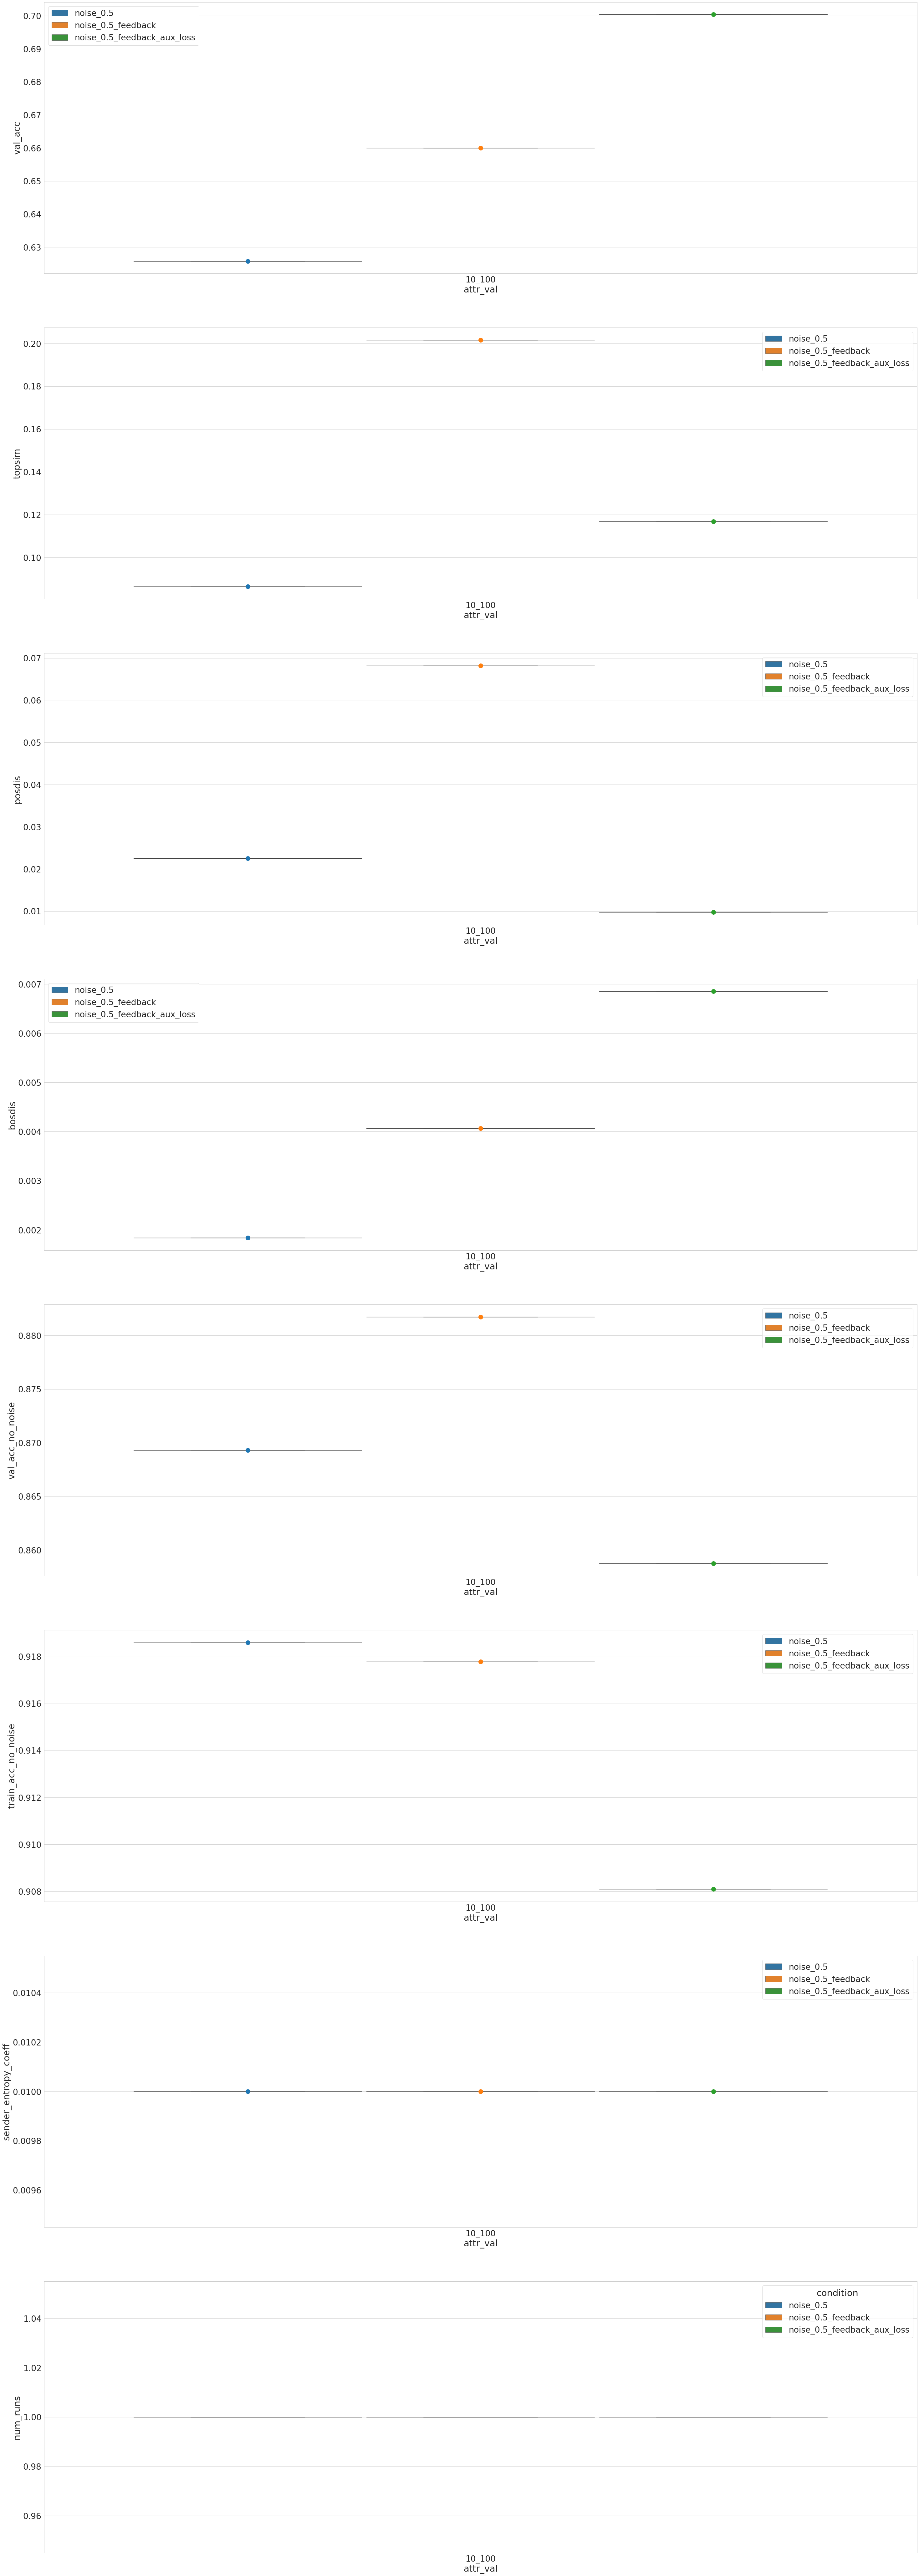

In [48]:
data["condition"] = data["noise"].map(lambda x: f"noise_{x}" if x > 0 else "baseline") + data["feedback"].map(lambda x: "_feedback" if x else "") + data["receiver_aux_loss"].map(lambda x: "_aux_loss" if x else "")

target_data = data.copy()

NUM_AGENTS = 1
target_data = target_data[target_data.num_agents == NUM_AGENTS]

MAX_LEN = 10
target_data = target_data[target_data.max_len == MAX_LEN]

VOCAB_SIZE = 2
target_data = target_data[target_data.vocab_size == VOCAB_SIZE]

LAYER_NORM = 1
target_data = target_data[target_data.layer_norm == LAYER_NORM]


# ATTR_VAL = "4_5"
# target_data = target_data[(target_data["attr_val"] == ATTR_VAL)]

# print(target_data.dir_name.unique())

# hue_order = None
# hue_order = ["baseline", "noise_0.1"]
hue_order = ["noise_0.5", "noise_0.5_feedback", "noise_0.5_feedback_aux_loss"]

# order = ["2_10", "3_5", "2_16", "4_4", "4_5", "3_10", "2_100"]
# order = ["2_100", "4_100", "10_100"]
order = ["10_100"]

target_hparam = "attr_val"

num_runs_data = target_data.groupby(["attr_val", "condition"]).size().reset_index()
# plt.figure(figsize=(30, 10))

metrics = ["val_acc", "topsim", "posdis", "bosdis", "val_acc_no_noise", "train_acc_no_noise", "sender_entropy_coeff"]
_, axes = plt.subplots(len(metrics)+1, 1, figsize=(50, 150))

# next_axis_idx = (0, 0)
for i, metric in enumerate(metrics):
    sns.boxplot(ax=axes[i], data=target_data, x=target_hparam, y=metric, order=order, hue="condition", hue_order=hue_order, boxprops=dict(alpha=.9), showfliers = False)
    ax = sns.swarmplot(ax=axes[i], data=target_data, x=target_hparam, y=metric, order=order, hue="condition", hue_order=hue_order, dodge=True, size=15)
    handles, labels = ax.get_legend_handles_labels()
    num_conditions = int(len(handles)/2) if not hue_order else len(hue_order)
    ax.legend(handles[:num_conditions], labels[:num_conditions])
    # plt.setp(ax.get_legend().get_texts(), fontsize='22')
    # if next_axis_idx[1] >= axes.shape[1]-1:
    #     next_axis_idx = (next_axis_idx[0]+1, 0)
    # else:
    #     next_axis_idx = (next_axis_idx[0], next_axis_idx[1]+1)
    
ax = sns.boxplot(ax=axes[-1], data=num_runs_data, x="attr_val", order=order, hue="condition", hue_order=hue_order, y=0)
ax.set_ylabel("num_runs")

name = "results"
plt.savefig("plots/"+name+".pdf", dpi=300)